In [0]:
import pandas as pd
import numpy as np

In [0]:
data = pd.read_excel("ICalls dataset (1).xlsx")

In [6]:
data.head()

,CALL_ID,START_TIMESTAMP,CALL_DURATION_SEC,CALLING_NUMBER_NOR,CALLED_NUMBER_NOR,RELEASE_CALSE_ID,IN_SWITCH_ID,IN_TRUNK_ID,IN_ACCOUNT_ID,IN_SERVICE_LEVEL_ID,IN_SERVICE_ID,OUT_SWITCH_ID,OUT_TRUNK_ID,OUT_ACCOUNT_ID,OUT_SERVICE_LEVEL_ID,OUT_SERVICE_ID,ROUTING_CLASS_ID,ROUTING_DESTINATION_ID,ROUTING_COUNTRY_ID,ORIG_COUNTRY_ID,ANSWERED,COST,REVENUE
0,1000284067810009984,2020-02-02 00:28:10,123,1.304815e+12,1063401614250,144,3,3814,381,8,1,3,2965,221,0,1,8,1067,146,241,1,0.681010,0.682035
1,1000284067810012912,2020-02-02 00:30:13,1,7.718661e+10,14589732215,144,3,3170,204,8,1,3,3829,190,0,1,8,272224,67,229,1,0.002583,0.002583
2,1000284067810009861,2020-02-02 00:09:18,33,2.239853e+12,2239769672380,144,3,3170,204,3,1,3,3021,130,0,1,4,1798,228,228,1,0.003025,0.003025
3,1000284067810012939,2020-02-02 00:29:47,43,2.457868e+13,24578661100030,144,3,3617,249,2,1,3,2897,256,0,1,2,540,80,80,1,0.007102,0.000000
4,1000284067810012946,2020-02-02 00:28:51,101,1.966744e+12,2238910138380,144,3,1353,234,2,1,3,3755,370,0,1,2,1778,228,107,1,0.013467,0.012120


In [13]:
data.START_TIMESTAMP.max()

Timestamp('2020-02-02 04:59:59')

In [0]:
#dropping START_TIMESTAMP
data.drop("START_TIMESTAMP",inplace=True,axis=1)

In [16]:
data.head()

,CALL_ID,CALL_DURATION_SEC,CALLING_NUMBER_NOR,CALLED_NUMBER_NOR,RELEASE_CALSE_ID,IN_SWITCH_ID,IN_TRUNK_ID,IN_ACCOUNT_ID,IN_SERVICE_LEVEL_ID,IN_SERVICE_ID,OUT_SWITCH_ID,OUT_TRUNK_ID,OUT_ACCOUNT_ID,OUT_SERVICE_LEVEL_ID,OUT_SERVICE_ID,ROUTING_CLASS_ID,ROUTING_DESTINATION_ID,ROUTING_COUNTRY_ID,ORIG_COUNTRY_ID,ANSWERED,COST,REVENUE
0,1000284067810009984,123,1.304815e+12,1063401614250,144,3,3814,381,8,1,3,2965,221,0,1,8,1067,146,241,1,0.681010,0.682035
1,1000284067810012912,1,7.718661e+10,14589732215,144,3,3170,204,8,1,3,3829,190,0,1,8,272224,67,229,1,0.002583,0.002583
2,1000284067810009861,33,2.239853e+12,2239769672380,144,3,3170,204,3,1,3,3021,130,0,1,4,1798,228,228,1,0.003025,0.003025
3,1000284067810012939,43,2.457868e+13,24578661100030,144,3,3617,249,2,1,3,2897,256,0,1,2,540,80,80,1,0.007102,0.000000
4,1000284067810012946,101,1.966744e+12,2238910138380,144,3,1353,234,2,1,3,3755,370,0,1,2,1778,228,107,1,0.013467,0.012120


In [0]:
!pip install pyod

In [0]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager


In [0]:
col_list = list(data.columns)
col_list.remove("REVENUE")

In [0]:
#lets look at any two columns to check for how anamolies are looking in the data

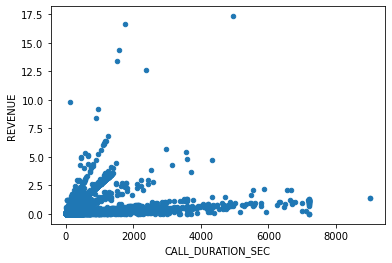

In [26]:
data.plot.scatter("CALL_DURATION_SEC","REVENUE")

In [0]:
#We can clearly see there difenetly anamolies in the data,Right now we are just looking at two variables,we can letron extend it for all the variables

In [0]:
#we will transform the data to one scale for our exercise going forward

In [0]:
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler().fit(data) 
data_minmax = minmax_scale.transform(data)

In [0]:
col_list = list(data.columns)
new_data = pd.DataFrame()
for i in range(len(col_list)):
  new_data[col_list[i]] = data_minmax[:,i]

In [53]:
new_data.head()

,CALL_ID,CALL_DURATION_SEC,CALLING_NUMBER_NOR,CALLED_NUMBER_NOR,RELEASE_CALSE_ID,IN_SWITCH_ID,IN_TRUNK_ID,IN_ACCOUNT_ID,IN_SERVICE_LEVEL_ID,IN_SERVICE_ID,OUT_SWITCH_ID,OUT_TRUNK_ID,OUT_ACCOUNT_ID,OUT_SERVICE_LEVEL_ID,OUT_SERVICE_ID,ROUTING_CLASS_ID,ROUTING_DESTINATION_ID,ROUTING_COUNTRY_ID,ORIG_COUNTRY_ID,ANSWERED,COST,REVENUE
0,5.960464e-08,0.013651,2.748050e-07,6.509159e-08,0.5375,0.0,0.962716,0.950166,1.000,0.0,0.0,0.726691,0.420530,0.0,1.0,1.00,0.002202,0.517986,0.860714,1.0,0.041042,0.039375
1,1.713634e-07,0.000111,1.625615e-08,8.928997e-10,0.5375,0.0,0.783528,0.362126,1.000,0.0,0.0,0.967158,0.317881,0.0,1.0,1.00,0.562821,0.233813,0.817857,1.0,0.000156,0.000149
2,5.960464e-08,0.003663,4.717319e-07,1.370981e-07,0.5375,0.0,0.783528,0.362126,0.375,0.0,0.0,0.742277,0.119205,0.0,1.0,0.50,0.003713,0.812950,0.814286,1.0,0.000182,0.000175
3,1.713634e-07,0.004772,5.176477e-06,1.504481e-06,0.5375,0.0,0.907902,0.511628,0.250,0.0,0.0,0.707765,0.536424,0.0,1.0,0.25,0.001112,0.280576,0.285714,1.0,0.000428,0.000000
4,1.713634e-07,0.011210,4.142128e-07,1.370455e-07,0.5375,0.0,0.277963,0.461794,0.250,0.0,0.0,0.946563,0.913907,0.0,1.0,0.25,0.003672,0.812950,0.382143,1.0,0.000812,0.000700


In [0]:
new_data.fillna(0,inplace=True)

In [0]:
#'Angle-based Outlier Detector (ABOD)
#Cluster-based Local Outlier Factor (CBLOF)
#Histogram-base Outlier Detection (HBOS)
#K Nearest Neighbors (KNN)
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'ABOD': ABOD(contamination=outliers_fraction),
        'CBLOF_':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature_Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'HBOS': HBOS(contamination=outliers_fraction),
        'Isolation_Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'KNN': KNN(contamination=outliers_fraction),
        'Average_KNN': KNN(method='mean',contamination=outliers_fraction)
}

In [0]:
df = pd.DataFrame()
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(new_data)
    # predict raw anomaly score
    scores_pred = clf.decision_function(new_data) * -1
        
    # prediction of a datapoint category outlier or inlier
    
    
    df[str(clf_name)+'outlier'+"score"] = scores_pred.tolist()
    
   

In [98]:
df.head()

,ABODoutlierscore,CBLOF_outlierscore,Feature_Baggingoutlierscore,HBOSoutlierscore
0,3.737819e+08,-3.010260,-5.449300,45.640886
1,2.162196e+26,-2.965015,-24644.261342,35.505899
2,1.388748e+12,-2.892670,-1.378142,33.313241
3,1.633505e+11,-2.715858,-1.826516,38.394626
4,7.579847e+12,-2.750907,-1.379551,38.332642


In [0]:
#merging the score with the original data

In [0]:
data["ABODoutlierscore"]= df["ABODoutlierscore"]
data["CBLOF_outlierscore"]= df["CBLOF_outlierscore"]
data["Feature_Baggingoutlierscore"]= df["Feature_Baggingoutlierscore"]
data["HBOSoutlierscore"]= df["HBOSoutlierscore"]

In [101]:
data.head()

,CALL_ID,CALL_DURATION_SEC,CALLING_NUMBER_NOR,CALLED_NUMBER_NOR,RELEASE_CALSE_ID,IN_SWITCH_ID,IN_TRUNK_ID,IN_ACCOUNT_ID,IN_SERVICE_LEVEL_ID,IN_SERVICE_ID,OUT_SWITCH_ID,OUT_TRUNK_ID,OUT_ACCOUNT_ID,OUT_SERVICE_LEVEL_ID,OUT_SERVICE_ID,ROUTING_CLASS_ID,ROUTING_DESTINATION_ID,ROUTING_COUNTRY_ID,ORIG_COUNTRY_ID,ANSWERED,COST,REVENUE,ABODoutlierscore,CBLOF_outlierscore,Feature_Baggingoutlierscore,HBOSoutlierscore
0,1000284067810009984,123,1.304815e+12,1063401614250,144,3,3814,381,8,1,3,2965,221,0,1,8,1067,146,241,1,0.681010,0.682035,3.737819e+08,-3.010260,-5.449300,45.640886
1,1000284067810012912,1,7.718661e+10,14589732215,144,3,3170,204,8,1,3,3829,190,0,1,8,272224,67,229,1,0.002583,0.002583,2.162196e+26,-2.965015,-24644.261342,35.505899
2,1000284067810009861,33,2.239853e+12,2239769672380,144,3,3170,204,3,1,3,3021,130,0,1,4,1798,228,228,1,0.003025,0.003025,1.388748e+12,-2.892670,-1.378142,33.313241
3,1000284067810012939,43,2.457868e+13,24578661100030,144,3,3617,249,2,1,3,2897,256,0,1,2,540,80,80,1,0.007102,0.000000,1.633505e+11,-2.715858,-1.826516,38.394626
4,1000284067810012946,101,1.966744e+12,2238910138380,144,3,1353,234,2,1,3,3755,370,0,1,2,1778,228,107,1,0.013467,0.012120,7.579847e+12,-2.750907,-1.379551,38.332642


In [0]:
#now we can take the scores to detect outliers 

In [119]:
#lets take an example of outliers
data.CALLED_NUMBER_NOR.max()

16336966966678749184

In [121]:
#lets see our scores here
data[data["CALL_DURATION_SEC"]==data.CALL_DURATION_SEC.max()]

,CALL_ID,CALL_DURATION_SEC,CALLING_NUMBER_NOR,CALLED_NUMBER_NOR,RELEASE_CALSE_ID,IN_SWITCH_ID,IN_TRUNK_ID,IN_ACCOUNT_ID,IN_SERVICE_LEVEL_ID,IN_SERVICE_ID,OUT_SWITCH_ID,OUT_TRUNK_ID,OUT_ACCOUNT_ID,OUT_SERVICE_LEVEL_ID,OUT_SERVICE_ID,ROUTING_CLASS_ID,ROUTING_DESTINATION_ID,ROUTING_COUNTRY_ID,ORIG_COUNTRY_ID,ANSWERED,COST,REVENUE,ABODoutlierscore,CBLOF_outlierscore,Feature_Baggingoutlierscore,HBOSoutlierscore
6074,1000284082110001549,9010,1.969474e+12,24586005615065,144,3,1391,234,2,1,3,3946,114,0,1,2,546,80,107,1,1.471633,1.426583,6.17381,-1.962856,-1.288763,9.775758


In [122]:
data["ABODoutlierscore"].quantile(.98)

4.895579601106817e+38

In [123]:
data["CBLOF_outlierscore"].quantile(.98)

-2.079759043367166

In [0]:
#Our scores are in thier 95+ percentile in this observation 
#hence using these scores we can detect the outliers#